In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from PIL import Image
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

#torch.cuda.is_available()

In [15]:
def angular_spectrum_propagation(U0, wvl, dx, z):
    """
    Propagates an optical field using the Bandlimited Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 4D torch tensor (batch, channel, x, y)
        wvl     : float (wavelength of light in meters)
        dx      : float (sampling interval in meters)
        z       : float (propagation distance in meters)

    Returns:
        U1  : the propagated field (same shape as U0)
    """
    batch, channel, original_height, original_width = U0.shape
    pad_height, pad_width = original_height // 2, original_width // 2

    z = torch.tensor([z], device=U0.device)
    # Pad input field
    U0_padded = torch.zeros((batch, channel, original_height + 2 * pad_height, original_width + 2 * pad_width), dtype=U0.dtype, device=U0.device)
    U0_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width] = U0

    ny, nx = U0_padded.shape[-2:]
    k = 2 * torch.pi / wvl

    # Create spatial frequency coordinates
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)
    fy = torch.fft.fftfreq(ny, dx, device=U0.device)
    FX, FY = torch.meshgrid(fx, fy)  # Ensure FX and FY have last two dimensions
    FX = FX.reshape(1,1, FX.shape[0], FX.shape[1])
    FY = FY.reshape(1,1, FY.shape[0], FY.shape[1])

    Delta_uy = 1 / (ny * dx)
    Delta_ux = 1 / (nx * dx)
    u_limity = 1 / (torch.sqrt((2 * Delta_uy * torch.abs(z)) ** 2 + 1) * wvl)
    u_limitx = 1 / (torch.sqrt((2 * Delta_ux * torch.abs(z)) ** 2 + 1) * wvl)
    H_limit = ((FY ** 2 / u_limity ** 2 + FX ** 2 * wvl ** 2) < 1) * ((FX ** 2 / u_limitx ** 2 + FY ** 2 * wvl ** 2) < 1)

    # Kernel
    H = torch.exp(1j * k * z * torch.sqrt(0j + 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    # Propagate
    U1_padded = torch.fft.fftshift(torch.fft.ifft2(torch.fft.fft2(torch.fft.ifftshift(U0_padded, dim=(-2, -1))) * H * H_limit), dim=(-2, -1))

    # Extract to initial size
    U1 = U1_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width]

    return U1

# Off-Axis Hologram Task

In this part you are going to explore off-axis holography. Propagate the given field by a distance of `z`. Interfere
the field with a plane wave which is tilted by 7° in both x and y.


As a task:
1) Find the center peak of the recorded intensity in Fourier space. Also, described a way how to calculate the position of the center peak
2) Reconstruct a nice image with a tile size of 100x100. Do not zero pad this extracted region. But instead work with the image of size 100x100. How do you need to change the pixel size `dx` for the wave propagation?
3) Plot the SSIM norm for the amplitude of the reconstructed hologram. Plot the SSIM over different tile sizes. Explain the shape of the curve. To compare it with the ground truth, you need to downsample the initial amplitude of the field with the following


```
downsampled = torch.nn.functional.interpolate(torch.abs(field).reshape(1,1, 1000, 1000),\
                                size=(backpropagated.shape[0], backpropagated.shape[1]), mode="bilinear")\
             .reshape(backpropagated.shape[0], backpropagated.shape[1])
```

In [16]:
x = torch.linspace(-500e-6, 500e-6, 1001)[:-1].to(device)
y = x.to(device)
X, Y = torch.meshgrid(x, y, indexing="ij")
X = X.to(device)
Y = Y.to(device)
dx = x[1] - x[0]

#amplitude = torch.tensor(np.array(Image.open("DP2-1536x864.jpg").convert('L'))) / 245
#phase = torch.tensor(np.array(Image.open("EPFL.jpg").convert('L'))) / 255

In [17]:
np.save("field_1000.npy", field.to("cpu"))

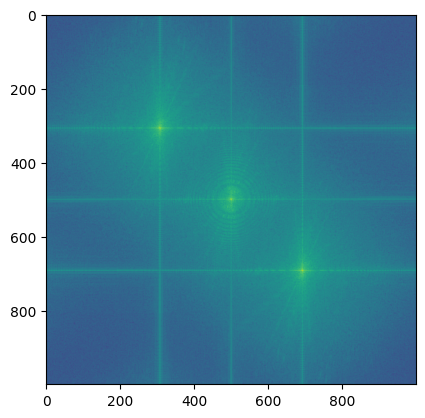

In [18]:
field = torch.tensor(np.load("field_1000.npy").reshape(1,1,1000,1000), device=device)

wvl = 633e-9
z = 1e-3
field_prop = angular_spectrum_propagation(field, wvl, dx, z).reshape(1000, 1000)

theta_x = 7 * np.pi / 180 
theta_y = 7 * np.pi / 180 
kx = (2 * np.pi / wvl) * np.sin(theta_x)
ky = (2 * np.pi / wvl) * np.sin(theta_y)



plane_wave = torch.exp(1j * ((kx * X)+ (ky * Y)))

interferred = torch.abs(field_prop + plane_wave)**2

ft = lambda x: torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(x)))
ift = lambda x: torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(x)))
plt.imshow(torch.abs(ft(interferred.cpu())**0.01))

In [27]:
# finding the frequency in Fourier space
# the plane wave corresponds to a certain frequency in fourier space (divide wave number kx by 2pi)
# fftfreq provides us with the frequencies in Fourier space if we tell it the sampling in real space
torch.argmin(torch.abs(torch.fft.fftshift(torch.fft.fftfreq(1000, dx)) + kx / 2 / 3.141592))

tensor(307)

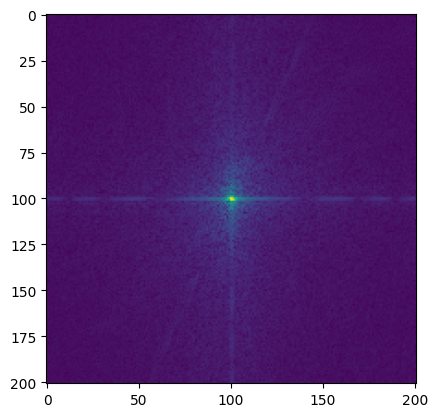

In [20]:
center = 307
o = 100

cropped = ift(ft(interferred)[center-o:center+o + 1, center-o:center+o + 1])
plt.imshow(torch.abs(ft(cropped.to("cpu")))**0.4)

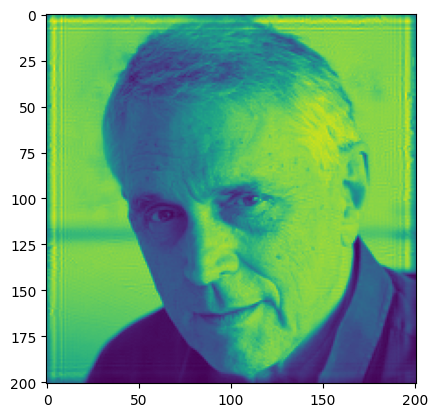

In [21]:
dx_new = dx * 1000 / cropped.shape[0]
backprop = angular_spectrum_propagation(cropped.reshape(1,1, cropped.shape[0], cropped.shape[1]),\
                                                     wvl, dx_new, -z).reshape(cropped.shape[0], cropped.shape[1])

plt.imshow(torch.abs(backprop).cpu())

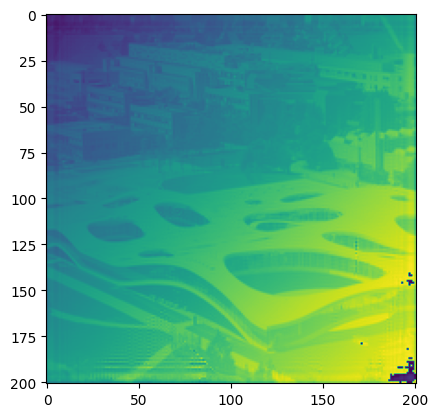

In [22]:
plt.imshow(torch.angle(backprop).cpu())

In [23]:
from torchmetrics.image import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)    

In [28]:
def eval():
    
    center = 307
    res_amplitude = []
    res_phase = []
    sizes = range(10, 150, 2)
    for s in sizes:
        o = s
        
        cropped = ift(ft(interferred)[center-o:center+o + 1, center-o:center+o + 1])
    
        dx_new = dx * 1000 / cropped.shape[0]
        backprop = angular_spectrum_propagation(cropped.reshape(1,1, cropped.shape[0], cropped.shape[1]),\
                                                             wvl, dx_new, -z).reshape(cropped.shape[0], cropped.shape[1])

        downsampled = torch.nn.functional.interpolate(amplitude.reshape(1,1, 1000, 1000),\
                                size=(backprop.shape[0], backprop.shape[1]), mode="bilinear")\
                .reshape(backprop.shape[0], backprop.shape[1])

        downsampled /= torch.max(downsampled)
        backprop_amp = abs(backprop) / torch.max(torch.abs(backprop))
        
        res_amplitude.append(ssim(torch.abs(backprop_amp.to(device)).unsqueeze(0).unsqueeze(0), downsampled.to(device).unsqueeze(0).unsqueeze(0)).cpu().numpy().item())
        #return downsampled, backprop_amp

    return sizes, res_amplitude, res_phase

In [29]:
sizes, res_amplitude, res_phase = eval()

For very small sizes, obviously the quality is almost similar.
But then, the quality drops as we are not taking enough information in Fourier space to recover the image nicely.

For very large sizes, we also take some part of the center DC peak which is mostly noise, so the quality decreases.

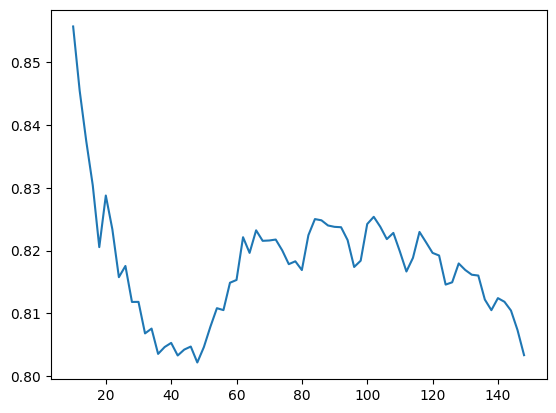

In [30]:
plt.plot(sizes, res_amplitude)